# Object detection with YOLOv2
This project is one of my assignments from the [Deep Learning Specialization course](https://www.coursera.org/specializations/deep-learning).

In [1]:
# Import dependencies

import os
import colorsys
import random
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt
import imageio
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from keras import backend as K
import base64
import json 
from keras import backend as K
from keras.models import load_model

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
%matplotlib notebook

## YOLO - You Only Look Once

In [3]:
sess = K.get_session()

### Step 1: Get features from pre-trained YOLOv2 model 

In [4]:
model = load_model('yolov2.h5')
features = model.output


Instructions for updating:
keep_dims is deprecated, use keepdims instead



/usr/local/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Step 2: Convert model features to boxes 

In [5]:
def features_to_boxes(features, anchors, num_classes):
    
    num_anchors = len(anchors)
    
    # Reshape to batch, height, width, num_anchors, box_params
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    
    # Dynamic implementation of conv dims for fully convolutional model
    conv_dims = K.shape(features)[1:3]  # assuming channels last
    
    # In YOLO the height index is the inner most iteration
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(features))
    features = K.reshape(
        features, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(features))
    box_xy = K.sigmoid(features[..., :2])
    box_wh = K.exp(features[..., 2:4])
    box_confidence = K.sigmoid(features[..., 4:5])
    box_class_probs = K.softmax(features[..., 5:])
    
    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims
    return box_xy, box_wh, box_confidence, box_class_probs

In [6]:
# Read anchors used to make predictions

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [7]:
anchors = read_anchors("../model/yolo_anchors.txt")

In [8]:
# Read classes

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [9]:
class_names = read_classes("../model/coco_classes.txt")

In [10]:
yolo_outputs = features_to_boxes(features, anchors, len(class_names))

### Step 3: Preprocess input image 

In [11]:
def preprocess_image(input_image, model_image_size):
    
    # When dealing with url input  
    #image = Image.open(urllib.request.urlopen(url))

    # Retrieve image shape (necessary to scale predicted bounding boxes later on)
    image_shape = input_image.size[::-1]
    
    # Convert images with 4 channels to 3 channels
    input_image = input_image.convert("RGB")
    
    # Resize image to correspond to model image size with BICUBIC interpolation mode (cubic spline interpolation)
    resized_image = input_image.resize(model_image_size, Image.BICUBIC)
    
    # Convert image to a numpy array
    image_data = np.array(resized_image, dtype='float32')
    
    # Normalize image
    image_data /= 255.
    
    # Add batch dimension 
    image_data = np.expand_dims(image_data, 0)  
    
    # Display the image 
    plt.show()

    return image_data, image_shape

### Step 4: Evaluate model outputs 

In [12]:
def yolo_evaluate(yolo_outputs, image_shape=(720., 1280.), max_output_size=10, score_threshold=.6, iou_threshold=.5):
    
    # Unpack bounding box params 
    xy, wh, confidence, class_probs = yolo_outputs
    
    # Step 1: Convert boxes information from (middle-point-coordinates, width-height) to corners coordinates 
    boxes = boxes_to_corners(xy, wh)
    
    # Step 2: eliminate boxes with low probabilities - filter boxes with scores lower than the threshold
    scores, boxes, classes = filter_boxes(confidence, boxes, class_probs, score_threshold)
    
    # Step 3: eliminate boxes with non-max scores and high overlap - filter boxes with IoU lower than the threshold
    scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_output_size, iou_threshold)
    
    # Step 4: Scale boxes to match input image size
    boxes = scale_boxes(boxes, image_shape)
    
    return scores, boxes, classes

In [13]:
# Convert boxes information from (middle-point-coordinates, width-height) to corners coordinates 

def boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)
    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]])  # x_max

In [14]:
# Eliminate boxes with low probabilities - filter boxes with scores lower than the threshold

def filter_boxes(confidence, boxes, class_probs, threshold = 0.6):
    
    # Compute the score for each box (object probability multiplied by class probability)
    scores = confidence * class_probs
    
    # Find class with maximum score for each box and respective score
    classes_with_max_score = K.argmax(scores, axis=-1)
    max_scores = K.max(scores, axis=-1)
    
    # Define a mask (binary filter) to discard boxes with score lower than the set threshold
    mask = (max_scores >= threshold)
    
    # Apply the mask to discard boxes data with the score lower than the set threshold
    scores = tf.boolean_mask(max_scores, mask)
    boxes =  tf.boolean_mask(boxes, mask)
    classes = tf.boolean_mask(classes_with_max_score, mask)
    
    return scores, boxes, classes

In [15]:
# Eliminate boxes with non-max scores and high overlap - filter boxes with IoU lower than the threshold

def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    # Initialize max_boxes tensor - to be used in tf.image.non_max_suppression()
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     
    
    # Initialize variable max_boxes_tensor
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    
    # Get the list of indices corresponding to boxes to keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=max_boxes)
    
    # Select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [16]:
# This function is not used for the inference; here just as an exercise. Non-max suppression function uses IoU

def iou(box1, box2):

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = max(inter_width, 0) * max(inter_height, 0)

    # Calculate the Union area 
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # Compute the IoU
    iou = inter_area / union_area
    
    return iou

In [17]:
# Scale boxes to match input image size

def scale_boxes(boxes, image_shape):
    
    # Retrieve image dimensions
    height = image_shape[0]
    width = image_shape[1]
    
    # Stack and reshape image dimensions to correspond to boxes coordinates (b_x, b_y, b_h, b_w)
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    image_dims = K.cast(image_dims, 'float32')
    
    # Normalize boxes by image dimensions
    boxes = boxes * image_dims
    
    return boxes

### Step 5: Draw predicted bounding boxes on the input image

In [18]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names):
    
    # Step 1: Generate colors for drawing predicted bounding boxes
    colors = generate_colors(class_names)
    
    # Load a font - workaround for ImageFont.truetype OSError
    file = open("../model/FiraMono-Medium.otf", "rb")
    bytes_font = BytesIO(file.read())
    font = ImageFont.truetype(bytes_font, size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    file.close()
    
    # Set bounding box line thickness
    thickness = (image.size[0] + image.size[1]) // 300
    for i, c in reversed(list(enumerate(out_classes))):
        
        # Retrieve box parameters
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        
        # Create output label
        label = '{} {:.2f}'.format(predicted_class, score)
        
        # Draw the bounding box on the image
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        
        # Retrieve box coordinates
        top, left, bottom, right = box
        
        # Limit bounding box coordinates to the image dimensions
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        
        # Set origin for the label text
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
            
        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [19]:
# Generate colors for drawing predicted bounding boxes

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    
    # Fixed seed for consistent colors across runs
    random.seed(10101)  
    
    # Shuffle colors to decorrelate adjacent classes
    random.shuffle(colors)  
    
    # Reset seed to default
    random.seed(None)  
    
    return colors

### Step 6: Make predictions

In [20]:
# Read input image file
image_file = "mazio_hambugs.jpg"
input_image = Image.open(image_file)

In [21]:
# Preprocess input images to match model input size 
image_data, image_shape = preprocess_image(input_image, model_image_size = (608, 608))

In [22]:
# Perform forward propagation (You Look Only Once)
out_scores, out_boxes, out_classes = sess.run(yolo_evaluate(yolo_outputs, image_shape), feed_dict={model.input: image_data,
                                                                                                K.learning_phase(): 0})

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
# Draw bounding boxes on the input image 
draw_boxes(input_image, out_scores, out_boxes, out_classes, class_names)

In [24]:
# Save edited image
output_file = 'output_image.png'
input_image.save(output_file, quality=90)

<IPython.core.display.Javascript object>


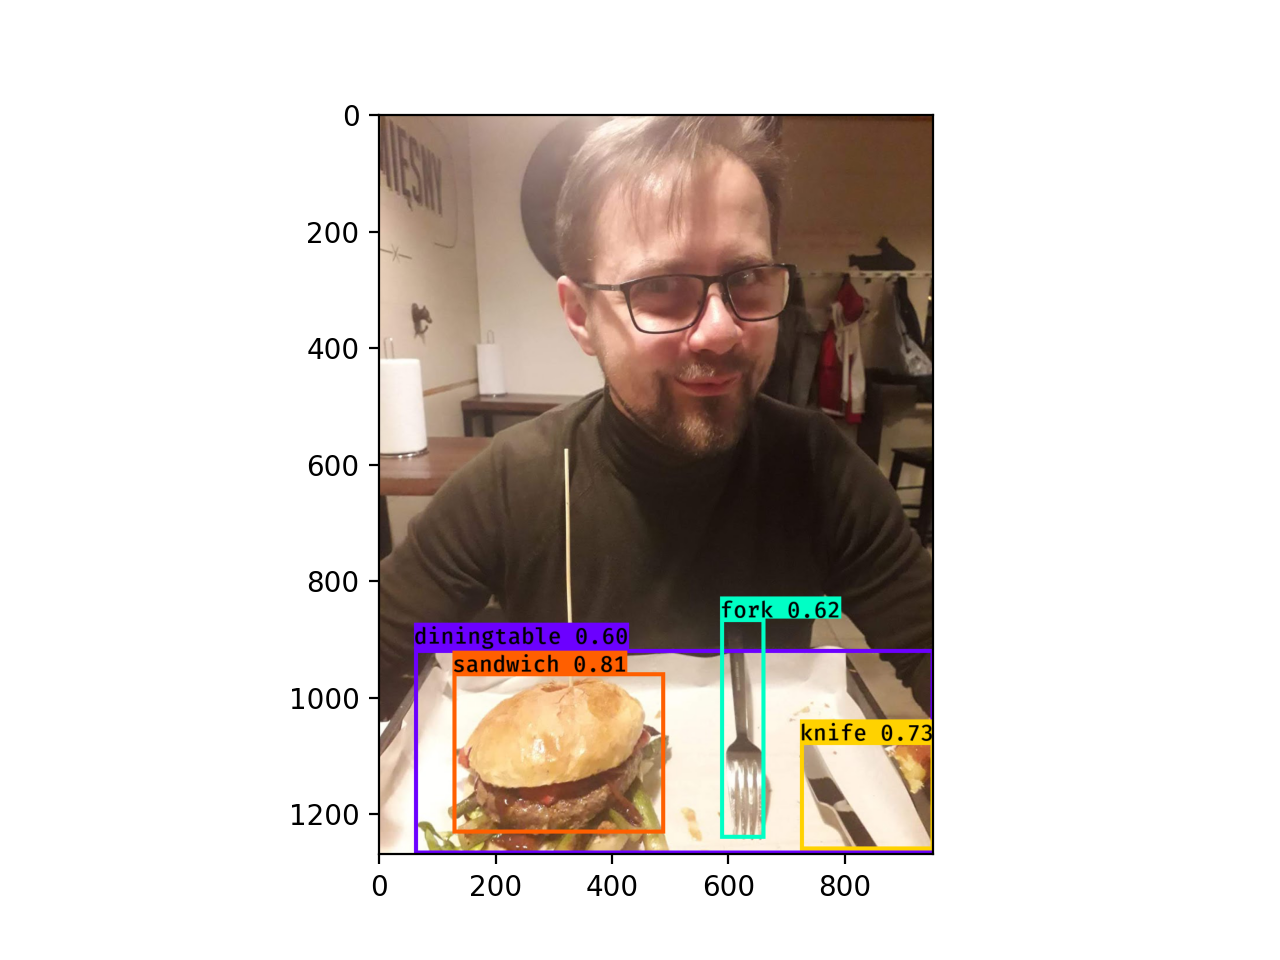

In [25]:
# Display the image 
output_image = imageio.imread(output_file)
plt.imshow(output_image)